In [1]:
import pandas
import numpy as np
import h5py
import seaborn as sns
%matplotlib inline

In [2]:
import re
import glob

In [3]:
np.isfinite(1)

True

## Get subject ids

In [232]:
reg = re.compile('.*/(?P<subject_id>[a-zA-Z]+)/processed/.*')
fns = glob.glob('/Users/gilles/Science/bistable_motion_pupil/data/bistable_motion/*/processed/*.hdf5')
subject_ids = [reg.match(fn).group(1) for fn in fns]

### Functions to extract data

In [381]:
def get_events(subject_id, run=1):
    h = h5py.File('/Users/gilles/Science/bistable_motion_pupil/data/bistable_motion/{subject_id}/processed/{subject_id}.hdf5'.format(**locals()))
    
    if 'BM_{run}'.format(**locals()) in h.keys():
        blocks = pandas.DataFrame(np.array(h['BM_{run}'.format(**locals())]['blocks']['block0_values']), 
                              columns=['end', 'start', 'x_pix', 'y_pix'])

        block_parameters = pandas.DataFrame(np.array(h['BM_{}'.format(run)]['parameters'])).set_index('trial_nr')

        events = pandas.DataFrame(np.array(h['BM_{run}'.format(**locals())]['events']))
        x = events.EL_timestamp.values
        events['block'] = np.piecewise(x, [(x > row.start) & (x < row.end) for ix, row in blocks.iterrows()], np.arange(len(blocks)))
        
        
        # THIS IS BECAUSE WEIRD DATA OF SUBJECT VV
        events = events[events.block < 6]
        
        events['block_type'] = events.block.map(lambda x: block_parameters.loc[x].run_type)

        return events
    else:
        return pandas.DataFrame(None)

In [423]:
def get_sounds(subject_id, run=1):
    
    h = h5py.File('/Users/gilles/Science/bistable_motion_pupil/data/bistable_motion/{subject_id}/processed/{subject_id}.hdf5'.format(**locals()))
    
    if 'BM_{run}'.format(**locals()) in h.keys():
        sounds = pandas.DataFrame(np.array(h['BM_{run}'.format(**locals())]['sounds']))
        blocks = pandas.DataFrame(np.array(h['BM_{run}'.format(**locals())]['blocks']['block0_values']), 
                                  columns=['end', 'start', 'x_pix', 'y_pix'])

        block_parameters = pandas.DataFrame(np.array(h['BM_{}'.format(run)]['parameters'])).set_index('trial_nr')

        x = sounds.EL_timestamp.values
        sounds['block'] = np.piecewise(x, [(x > row.start) & (x < row.end) for ix, row in blocks.iterrows()], np.arange(len(blocks)))
        
        sounds = sounds[sounds.block <= block_parameters.index.max()]

        sounds['block_type'] = sounds.block.map(lambda x: block_parameters.loc[x].run_type)

        sounds = sounds.set_index('exp_timestamp')
        
        return sounds
    
    else:
        return pandas.DataFrame(None)



In [378]:
def get_block_parameters(subject_id):
    h = h5py.File('/Users/gilles/Science/bistable_motion_pupil/data/bistable_motion/{subject_id}/processed/{subject_id}.hdf5'.format(**locals()))

    if 'BM_1' in h.keys():
        block_parameters1 = pandas.DataFrame(np.array(h['BM_1']['parameters'])).set_index('trial_nr')
        block_parameters1['session'] = 1
        block_parameters1['trial'] = np.arange(len(block_parameters1))
        
        trials1 = pandas.DataFrame(np.array(h['BM_1']['trials']))
        trials1['session'] = 1
    else:
        block_parameters1 = pandas.DataFrame([])
        trials1 = pandas.DataFrame([])
    
    if 'BM_2' in h.keys():
        block_parameters2 = pandas.DataFrame(np.array(h['BM_2']['parameters'])).set_index('trial_nr')
        block_parameters2['session'] = 2
        block_parameters2['trial'] = np.arange(len(block_parameters2))
        trials2 = pandas.DataFrame(np.array(h['BM_2']['trials']))
        trials2['session'] = 2 
        
    else:
        block_parameters2 = pandas.DataFrame([])
        trials2 = pandas.DataFrame([])
        
    block_parameters = pandas.concat((block_parameters1, block_parameters2), ignore_index=True)
    trials = pandas.concat((trials1, trials2), ignore_index=True)    
    
    block_parameters = block_parameters.merge(trials, left_on=['trial', 'session'], right_on=['trial_start_index', 'session'])
    block_parameters['duration_exp'] = block_parameters['trial_end_exp_timestamp'] - block_parameters['trial_start_exp_timestamp']
    block_parameters['duration_EL'] = block_parameters['trial_end_EL_timestamp'] - block_parameters['trial_start_EL_timestamp']
    
    return block_parameters

In [379]:
block_parameters = []
for sid in subject_ids:
    bp = get_block_parameters(sid)
    bp['subject_id'] = sid
    
    block_parameters.append(bp)
    
block_parameters = pandas.concat(block_parameters, ignore_index=True)

# Number of 100% complete subjects is 22 out of 31

In [345]:
subject_info = block_parameters.groupby(['subject_id']).size()

In [346]:
subject_info.shape

(31,)

In [347]:
(subject_info == 12).sum()

22

In [354]:
tmp = block_parameters.pivot_table(index=['subject_id'], columns=['type'], values='duration_EL', aggfunc=len, fill_value=0)
tmp = pandas.melt(tmp.reset_index(), id_vars=['subject_id'], value_name='n')

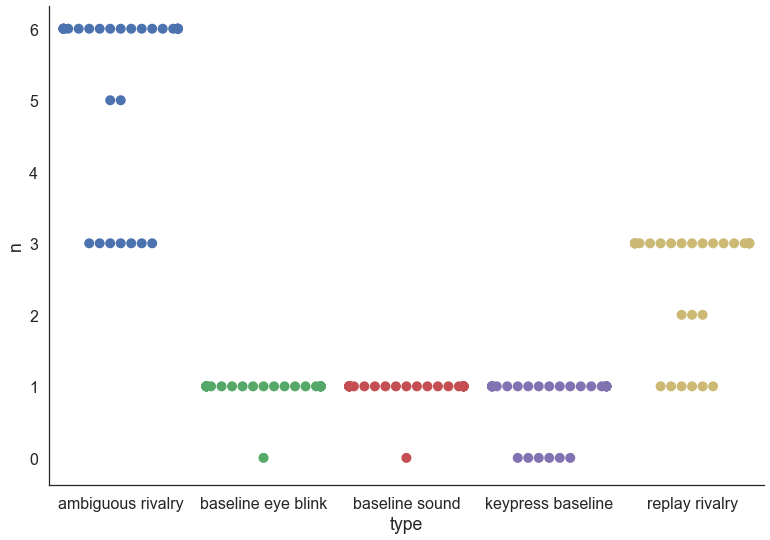

In [357]:
sns.swarmplot('type', 'n', data=tmp, size=10)
sns.despine()

# Replay rivalry condition is sometimes  5 instead of 8 minutes, only in 2nd session

In [446]:
sns.set_style('white')
sns.set_context('poster')

In [447]:
trial_type_mapping = {0:'ambiguous rivalry',
                      1:'replay rivalry',
                      2:'baseline eye blink',
                      3:'baseline sound',
                      4:'keypress baseline'}

In [448]:
block_parameters['type'] = block_parameters.run_type.map(trial_type_mapping)

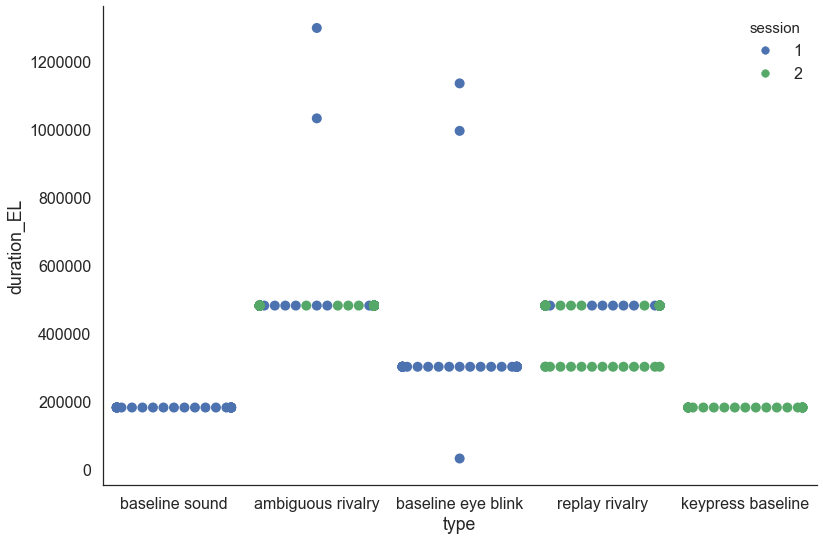

In [449]:
sns.swarmplot('type', 'duration_EL', 'session', data=block_parameters, size=10)
sns.despine()

Subject dac almost imeediately quit with his baseline eye blink run

In [459]:
block_parameters[block_parameters.duration_EL < 100000][['subject_id', 'trial', 'session', 'type']]

,subject_id,trial,session,type
62,dac,2,1,baseline eye blink


Subjects esm and mp have some very long runs

In [461]:
block_parameters[block_parameters.duration_EL > 600000][['subject_id', 'trial', 'session', 'type']]


,subject_id,trial,session,type
110,esm,2,1,baseline eye blink
111,esm,3,1,ambiguous rivalry
198,mp,2,1,baseline eye blink
199,mp,3,1,ambiguous rivalry


For esm, sesion 1, run 3, the time between the first and last button press is still almost exactly 480 seconds (8 minutes)

In [467]:
tmp = get_events('esm', 1)
tmp[tmp.block == 3].exp_timestamp.max() - tmp[tmp.block == 3].exp_timestamp.min()

475115.60000000009

Same goes for mp, session 1, run 3

In [470]:
tmp = get_events('mp', 1)
tmp[tmp.block == 3].exp_timestamp.max() - tmp[tmp.block == 3].exp_timestamp.min()

469031.80000000005

# Subject MSG has no event/sound data for run 1

In [472]:
key = get_events('msg', 1)

KeyError: "Unable to open object (Object 'blocks' doesn't exist)"

This is weird, because there is a .msg file 

In [475]:
!head /Users/gilles/Dropbox/Science/bistable_motion_pupil/data/bistable_motion/msg/raw/BM_1.msg

** CONVERTED FROM /home/shared/bistable_motion/data/bistable_motion/msg/raw/BM_1.edf using edfapi 3.0 Linux Dec  1 2008 on Wed Oct  5 16:36:38 2016
** DATE: Fri Sep  2 11:37:06 2016
** TYPE: EDF_FILE BINARY EVENT SAMPLE TAGGED
** VERSION: EYELINK II 1
** SOURCE: EYELINK CL
** EYELINK II CL v4.594 Jul  6 2012
** CAMERA: EyeLink CL Version 1.4 Sensor=CJB
** SERIAL NUMBER: CL1-65C10
** CAMERA_CONFIG: 65C10140.SCD
**


For run 2 of msg there is nothing at all. (Also not .msg file!)

In [478]:
key = get_events('msg', 2)

In [479]:
key

""


# As one would hope, key presses almost only occur in rivalry and keypress baseline condition

*But* there is something wrong with the first run of vv

In [409]:
keys = []
for sid in subject_ids:
    for run in [1,2]:
        if sid not in ['msg']:
            key = get_events(sid, run)
            key['subject_id'] = sid
            key['run'] = run

            keys.append(key)

keys = pandas.concat(keys, ignore_index=True)
keys['type'] = keys['block_type'].map(trial_type_mapping)
keys['button'] = keys['event_type']

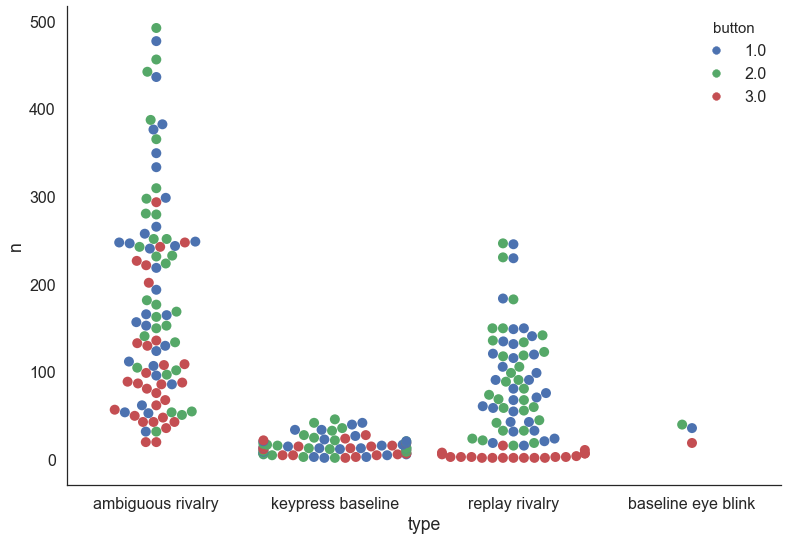

In [410]:
tmp = keys.groupby(['subject_id', 'type', 'button']).size().to_frame('n').reset_index()
sns.swarmplot('type', 'n', 'button', data=tmp, size=10)
sns.despine()

The only weird guy is the first run of vv

In [431]:
keys[keys.type == 'baseline eye blink']

,EL_timestamp,block,block_type,event_type,exp_timestamp,key,modifier,run,scancode,subject_id,up_down,type,button
21416,14251633.0,2.0,2.0,1.0,502793.6,1.0,0.0,1,0.0,vv,b'Down',baseline eye blink,1.0
21417,14253092.0,2.0,2.0,2.0,504251.9,2.0,0.0,1,0.0,vv,b'Down',baseline eye blink,2.0
21418,14263259.0,2.0,2.0,1.0,514417.9,1.0,0.0,1,0.0,vv,b'Down',baseline eye blink,1.0
21419,14264834.0,2.0,2.0,2.0,515992.8,2.0,0.0,1,0.0,vv,b'Down',baseline eye blink,2.0
21420,14265809.0,2.0,2.0,1.0,516967.8,1.0,0.0,1,0.0,vv,b'Down',baseline eye blink,1.0
21421,14266643.0,2.0,2.0,2.0,517801.1,2.0,0.0,1,0.0,vv,b'Down',baseline eye blink,2.0
21422,14268026.0,2.0,2.0,1.0,519184.3,1.0,0.0,1,0.0,vv,b'Down',baseline eye blink,1.0
21423,14269276.0,2.0,2.0,2.0,520434.2,2.0,0.0,1,0.0,vv,b'Down',baseline eye blink,2.0
21424,14270560.0,2.0,2.0,1.0,521717.5,1.0,0.0,1,0.0,vv,b'Down',baseline eye blink,1.0
21425,14271768.0,2.0,2.0,2.0,522925.8,2.0,0.0,1,0.0,vv,b'Down',baseline eye blink,2.0


# Sounds almost only occur in rivalry and sound baseline condition

But again,  there is something wrong with the first run of vv

In [427]:
sounds = []
for sid in subject_ids:
    for run in [1,2]:
        print(sid, run)
        if sid not in ['msg']:
            sound = get_sounds(sid, run)
            sound['subject_id'] = sid
            sound['run'] = run

            sounds.append(sound)

sounds = pandas.concat(sounds, ignore_index=True)
sounds['type'] = sounds['block_type'].map(trial_type_mapping)

A 1
A 2
aa 1
aa 2
ak 1
ak 2
ar 1
ar 2
avdv 1
avdv 2
ck 1
ck 2
dac 1
dac 2
dav 1
dav 2
dl 1
dl 2
erc 1
erc 2
es 1
es 2
esm 1
esm 2
evg

/Users/gilles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 1
evg 2
gf 1
gf 2
gmf 1
gmf 2
jts 1
jts 2
lp 1
lp 2
mk 1
mk 2
mm 1
mm 2
mp 1
mp 2
msg 1
msg 2
nh 1
nh 2
nk 1
nk 2
rr 1
rr 2
sp 1
sp 2
ts 1
ts 2
ui 1
ui 2
vk 1
vk 2
vr 1
vr 2
vv 1
vv 2
zase 1
zase 2


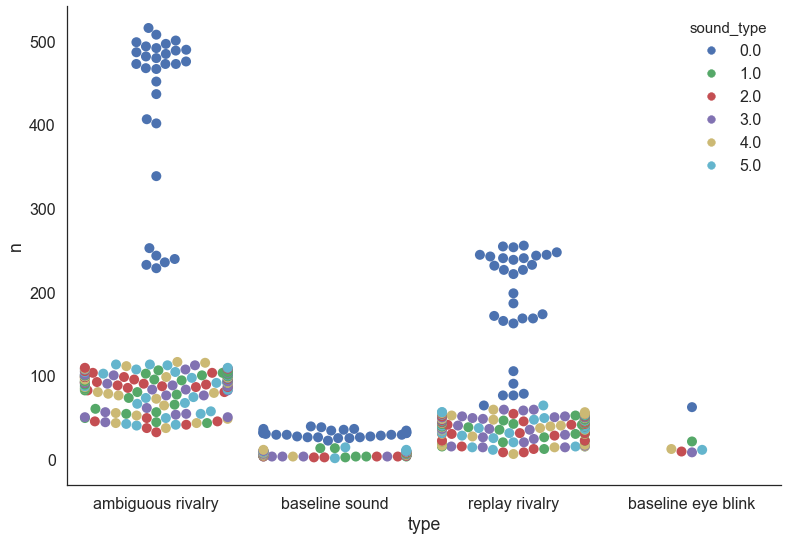

In [428]:
tmp = sounds.groupby(['subject_id', 'type', 'sound_type']).size().to_frame('n').reset_index()
sns.swarmplot('type', 'n', 'sound_type', data=tmp, size=10)
sns.despine()

Again, problem with first run of vv:

In [430]:
sounds[sounds.type == 'baseline eye blink']

,EL_timestamp,block,block_type,run,sound_type,subject_id,type
35996,14236907.0,2.0,2.0,1,0.0,vv,baseline eye blink
35997,14239124.0,2.0,2.0,1,1.0,vv,baseline eye blink
35998,14242049.0,2.0,2.0,1,0.0,vv,baseline eye blink
35999,14248858.0,2.0,2.0,1,4.0,vv,baseline eye blink
36000,14249341.0,2.0,2.0,1,0.0,vv,baseline eye blink
36001,14250116.0,2.0,2.0,1,4.0,vv,baseline eye blink
36002,14251000.0,2.0,2.0,1,0.0,vv,baseline eye blink
36003,14252517.0,2.0,2.0,1,1.0,vv,baseline eye blink
36004,14260917.0,2.0,2.0,1,0.0,vv,baseline eye blink
36005,14263993.0,2.0,2.0,1,5.0,vv,baseline eye blink


# Export data

In [485]:
sounds[~((sounds.subject_id == 'vv') & (sounds.run == 1))].to_csv('/Users/gilles/Dropbox/Science/bistable_motion_pupil/sounds.csv')

In [491]:
keys[~((keys.subject_id == 'vv') & (keys.run == 1))].to_csv('/Users/gilles/Dropbox/Science/bistable_motion_pupil/keys.csv')